In [12]:
#Question 1. There are 5 jurors in a courtroom. 
# Each of them can correctly identify the guilt of the defendant with 70% probability, 
# independent of one another. What is the probability that the jurors will jointly reach 
# the correct verdict if the final decision is by majority vote?

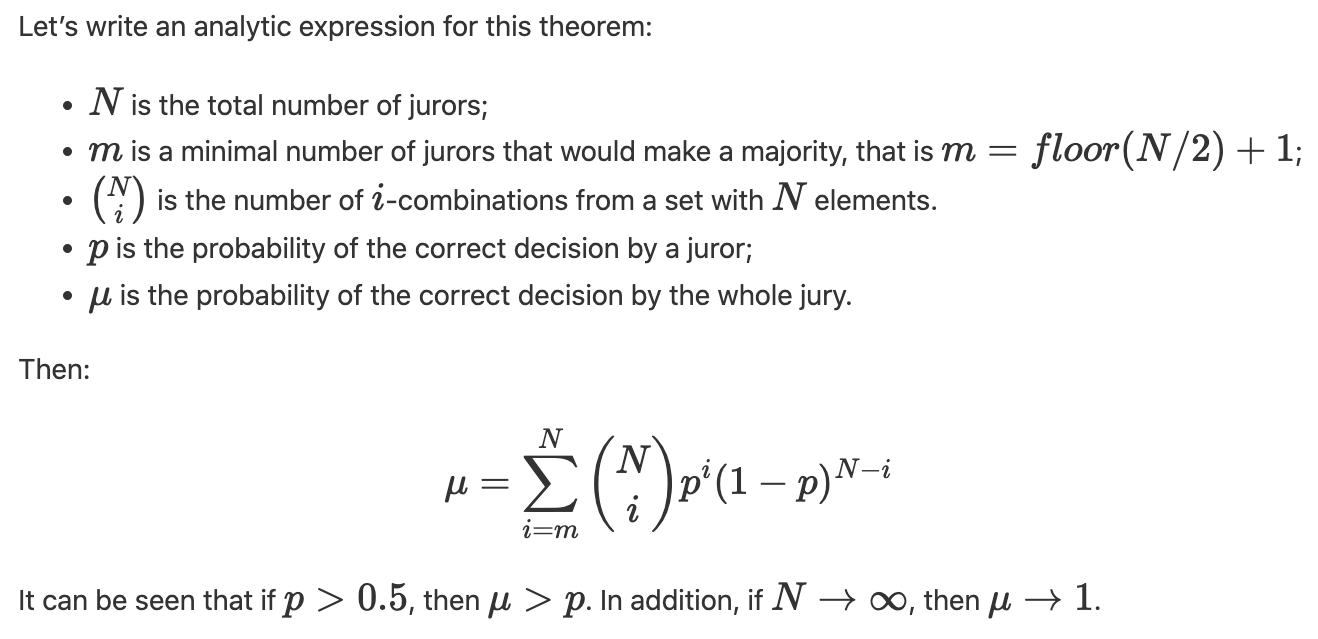

In [396]:
from IPython import display 
display.Image("Desktop/screenshot1.png")

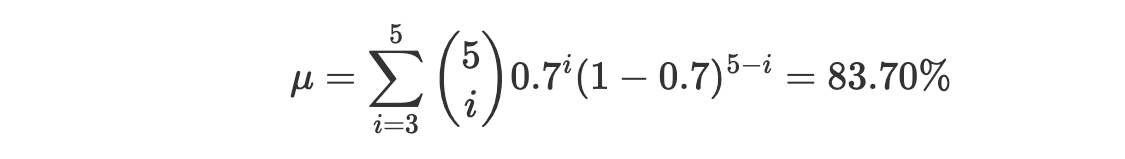

In [398]:
display.Image("Desktop/screenshot2.png")
#Ensemble

In [14]:
#Problem
#Predict whether the customer will repay their credit within 90 days. 
#This is a binary classification problem; 
#we will assign customers into good or bad categories based on our prediction.

In [15]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [16]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [17]:
#function that will replace NaN values with the median for each column.
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [18]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [19]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [20]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

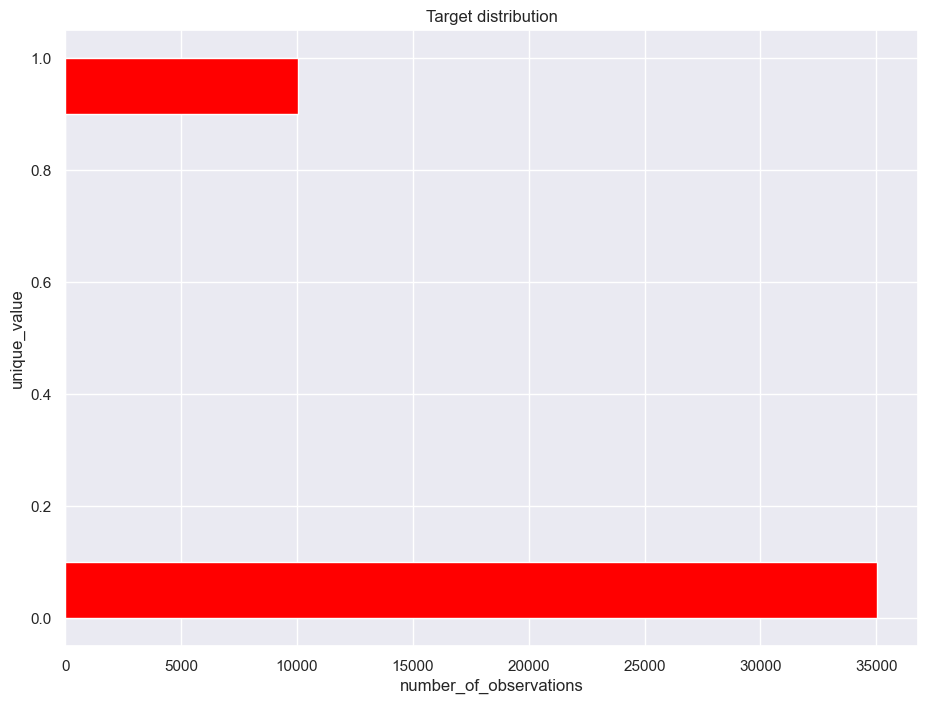

In [21]:
#class balance
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [22]:
#Separate the input variable names by excluding the target:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [23]:
#fill NaN values
table = fill_nan(data)

In [24]:
#Separate the target variable and input features:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [28]:
#Bootstrapping
#Question 2. Make an interval estimate of the average age for the customers who delayed repayment 
# at the 90% confidence level. Use the example from the article as reference, if needed. 
# Also, use np.random.seed(0) as before. What is the resulting interval estimate?

In [57]:
#function to generate bootstrap undergroups
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
#function for interval scoring
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return list(map(lambda x: round(x,2), boundaries))
delayed_repayment = data[data['SeriousDlqin2yrs'] == 1]['age'].values
np.random.seed(0)
del_rep_scores = [np.mean(sample) for sample in get_bootstrap_samples(delayed_repayment, len(data))]
print("Customers who delayed repayment:  average age",  stat_intervals(del_rep_scores, 0.1))

Customers who delayed repayment:  average age [45.71, 46.14]


In [217]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import scipy 
from scipy.special import softmax

In [140]:
lr = LogisticRegression(random_state=5, class_weight="balanced", max_iter=1000)

In [141]:
#find the best regularization coefficient
#look at the ROC AUC against different values of the parameter C
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [142]:
#Question 3. Perform a Grid Search with the scoring metric “roc_auc” for the parameter C. 
# Which value of the parameter C is optimal?

In [143]:
gcv = GridSearchCV(lr, parameters, scoring='roc_auc', n_jobs=-1, cv=skf)
gcv.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [144]:
gcv.best_params_

{'C': 0.001}

In [145]:
#Question 4. Can we consider the best model stable? 
#The model is stable if the standard deviation on validation is less than 0.5%. 
#Save the ROC AUC value of the best model; it will be useful for the following tasks.

In [146]:
print(str(round(gcv.cv_results_['std_test_score'][1] * 100, 2)) + '%' + ' > 0.5% :  not stable ')

0.81% > 0.5% :  not stable 


In [147]:
#roc auc of the best model
gcv.best_score_

0.8089120626797153

In [148]:
#Feature importance
#Question 5. Feature importance is defined by the absolute value of its corresponding coefficient. 
# First, you need to normalize all of the feature values so that it will be valid to compare them. 
# What is the most important feature for the best logistic regression model?

In [151]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr2 = LogisticRegression(random_state=5, class_weight="balanced", max_iter=1000, C=0.001)
lr2.fit(X_scaled,y)

LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000,
                   random_state=5)

In [207]:
lr2.coef_[0]

array([-0.41670229,  0.72342698, -0.02409605,  0.51678764,  0.19355764,
       -0.16314632,  0.1014432 ])

In [215]:
features = pd.DataFrame(
{'abs_coef': abs(lr2.coef_[0])},
index = data.columns.drop('SeriousDlqin2yrs'))
features.sort_values('abs_coef', ascending = False)
#The most important feature is 'NumberOfTime30-59DaysPastDueNotWorse'

,abs_coef
NumberOfTime30-59DaysPastDueNotWorse,0.723427
NumberOfTimes90DaysLate,0.516788
age,0.416702
NumberOfTime60-89DaysPastDueNotWorse,0.193558
MonthlyIncome,0.163146
NumberOfDependents,0.101443
DebtRatio,0.024096


In [216]:
#Question 6. Calculate how much DebtRatio affects our prediction using the softmax function. What is its value?

In [225]:
softmax = np.exp(lr2.coef_[0])/np.sum(np.exp(lr2.coef_[0]))

In [227]:
#coeff for DebtRatio:
softmax[2]

0.11426375283065272

In [229]:
#Question 7. Let’s see how we can interpret the impact of our features. 
# For this, recalculate the logistic regression with absolute values, that is without scaling. 
# Next, modify the customer’s age by adding 20 years, keeping the other features unchanged. 
# How many times will the chance that the customer will not repay their debt increase? 

In [293]:
#increasing age
X4 = X.copy()
X4['age'] = X4['age'] + 20

In [294]:
#fitting pure and increasing LogRegr
lr3 = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
lr3.fit(X,y)
lr4 = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
lr4.fit(X4,y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [295]:
#pure features
features = pd.DataFrame(
{'coef': lr3.coef_[0]},
index = data.columns.drop('SeriousDlqin2yrs'))
features.sort_values('coef', ascending = False)

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.460630
NumberOfTimes90DaysLate,0.404841
NumberOfTime60-89DaysPastDueNotWorse,0.238019
NumberOfDependents,0.165990
DebtRatio,-0.000008
MonthlyIncome,-0.000011
age,-0.013485


In [296]:
#increasing age LR features
features2 = pd.DataFrame(
{'coef': lr4.coef_[0]},
index = data.columns.drop('SeriousDlqin2yrs'))
features2.sort_values('coef', ascending = False)

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.443701
NumberOfTimes90DaysLate,0.391997
NumberOfTime60-89DaysPastDueNotWorse,0.232903
NumberOfDependents,0.188607
DebtRatio,-0.000010
MonthlyIncome,-0.000013
age,-0.009033


In [298]:
#age coeff:
lr3.coef_[0][0], lr4.coef_[0][0]

(-0.013485070120735633, -0.009033083961273645)

In [306]:
#How many times chance that the customer will not repay their debt increase:
round(lr4.coef_[0][0]/lr3.coef_[0][0], 2)

0.67

In [307]:
#Random Forest

In [331]:
from sklearn.ensemble import RandomForestClassifier

In [332]:
#Initialize Random Forest with 100 trees and balance target classes:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [333]:
#search for parameters:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [334]:
skf

StratifiedKFold(n_splits=5, random_state=5, shuffle=True)

In [335]:
#Question 8. How much higher is the ROC AUC of the best random forest model 
# than that of the best logistic regression on validation? Select the closest answer.

In [336]:
rf_best = GridSearchCV(rf, parameters, scoring='roc_auc', n_jobs=-1, cv=skf)
rf_best.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [337]:
rf_best.best_params_

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}

In [338]:
rf_best.best_score_

0.8357785451032532

In [339]:
#difference between ROC AUC of RF and LR:
round(rf_best.best_score_ - gcv.best_score_, 3)

0.027

In [340]:
#Question 9. What feature has the weakest impact in the Random Forest model?

In [346]:
#relearning the best RF model: 
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced",
    max_depth=10, max_features=2, min_samples_leaf=9
)
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=9, n_jobs=-1, random_state=42)

In [355]:
features = pd.DataFrame(
{'coef': rf.feature_importances_},
index = X.columns)
features.sort_values('coef', ascending=False)
#the weakest feature: NumberOfDependents

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.300290
NumberOfTimes90DaysLate,0.278749
NumberOfTime60-89DaysPastDueNotWorse,0.156534
age,0.115860
DebtRatio,0.076082
MonthlyIncome,0.057994
NumberOfDependents,0.014491


In [359]:
#Question 10. What is the most significant advantage of using Logistic Regression 
#versus Random Forest for this problem?

#Feature interpretability

In [361]:
#Bagging

In [362]:
#Import modules and set up the parameters for bagging:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [363]:
#Question 11. Fit a bagging classifier with random_state=42. 
#For the base classifiers, use 100 logistic regressors and use RandomizedSearchCV.
#What is the best ROC AUC you achieve?

In [364]:
%%time
lr = BaggingClassifier(LogisticRegression(class_weight='balanced'),  n_estimators=100, n_jobs=-1, random_state=42)
lr_gc = RandomizedSearchCV(lr, parameters, n_jobs=-1, 
                           scoring='roc_auc', cv=skf, n_iter=20, random_state=1, verbose=True)
lr_gc.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/ivvvv/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ivvvv/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

CPU times: user 456 ms, sys: 169 ms, total: 624 ms
Wall time: 4min 47s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                                               n_estimators=100, n_jobs=-1,
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state=1, scoring='roc_auc', verbose=True)

In [365]:
lr_gc.best_score_

0.8087951623513827

In [ ]:
#Question 12. Give an interpretation of the best parameters for bagging. 
#Why are these values of max_features and max_samples the best?

In [366]:
#Less correlation between single models